In [48]:
from bokeh.plotting import figure
from bokeh.io import push_notebook, output_notebook, show
import math
from bokeh.models.widgets import Select
from bokeh.models.glyphs import Circle
from bokeh.layouts import column
#from re import match
import numpy as np
from sklearn import cluster, datasets
from bokeh.models import HoverTool, PanTool, WheelZoomTool, ColumnDataSource
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
# from word_cloud_master.wordcloud import wordcloud
import networkx as nx
import matplotlib as mpl
#import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

#self-defined module
import data_parser
import spacy
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
output_notebook()


[nltk_data] Downloading package punkt to /Users/zhiliyang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhiliyang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading BokehJS ...

The codes below read lyrics data from csv dataset, load stop words from a local file and initialize a punctuation list for filtering split characters in texts.

In [49]:

CHARACTERS_TO_SPLIT = """\[\].,():;-!?\n\""""
with open("data/stopwords.txt", "r") as f:
    STOP_WORDS = set(f.read().strip().split("\n"))
    
songs_df = data_parser.parse_csv_data('./data/lyrics.csv', 'ISO-8859-1')
songs_feature_names = data_parser.extract_column_names(songs_df)

songs_dic_list = data_parser.build_row_dic_list(songs_df, songs_feature_names)

The codes below group songs of each artist, and then use **nltk to toknize to each artist's songs**. For removing those senseless words and characters from text, **STOP_WORDS, CHARACTERS_TO_SPLIT and the stopwords list imported from nltk package** are used for filtering. What's more, the codes also calculate the frequency of each token in it's document by **FreqDist** which is offered by nltk.

In [52]:

artist_list_dic = {}
# Merge the song texts from same artist.
for song in songs_dic_list:
    if song['artist'] in artist_list_dic:
        artist_list_dic[song['artist']]['text'] += song['text']
    else:
        artist_list_dic[song['artist']] = {'artist': song['artist'], 'text': song['text']}


word_freq_dic = {}
for k, v in artist_list_dic.items():
    tok_list = word_tokenize(artist_list_dic[k]['text'])
    filtered_words = [tok for tok in tok_list if tok.lower() not in stopwords.words('english') and tok.lower() not in CHARACTERS_TO_SPLIT and tok.lower() not in STOP_WORDS]
    word_freq = FreqDist(filtered_words)
    word_freq_dic[k] = word_freq


In [53]:
from bokeh.palettes import Dark2_5 as palette
from bokeh.transform import factor_cmap
from bokeh.layouts import column
from bokeh.models import CustomJS

keys = [t[0] for t in word_freq_dic['ABBA'].most_common(20)]
values = [t[1] for t in word_freq_dic['ABBA'].most_common(20)]
legends = [str(i)+"-"+str(t[0]) for i, t in enumerate(word_freq_dic['ABBA'].most_common(20))]
freq_plot = figure(plot_width=700, plot_height=700)
cache = [{}]
for k, v in word_freq_dic.items():
    legends = [str(i)+"-"+str(t[0]) for i, t in enumerate(word_freq_dic[k].most_common(20))]
    values = [t[1] for t in word_freq_dic[k].most_common(20)]
    cache[0][k] = {'values': values, 'legends': legends}
cache_source = ColumnDataSource(data = dict(cache = cache))
freq_source = ColumnDataSource(data = dict(x = range(20), top = values, legend=legends))
freq_plot.vbar(x='x', top='top',source=freq_source, width=0.9, bottom=0, legend="legend")
freq_plot.y_range.start = 0


artists = list(word_freq_dic.keys())


def callback(source=freq_source, cache=cache_source, window=None):
    artist = cb_obj.value
    values = cache.data['cache'][0][artist]['values']
    legends = cache.data['cache'][0][artist]['legends']
    source.data['top'] = values
    source.data['legend'] = legends
    source.change.emit()


select = Select(title="Artists:", value=artists[0], options=artists, callback=CustomJS.from_py_func(callback))

layout = column(freq_plot, select)
show(layout)



## Plot 1: the top 10 most common used words of each artist
In this plot, it displays the most common words used in each artist. There are some common words among almost all artists, such as **love**, **baby** and **oh**. In addition, we can find a lot of "bad" words in Eminem's songs (the main reason is he is a rapper, and it is really common to add some slangs into the songs).

## Data Visualization 2
In the codes below, we try to apply **wordcloud** to generate a visualization of different words used among those artists.

(-0.5, 1999.5, 999.5, -0.5)

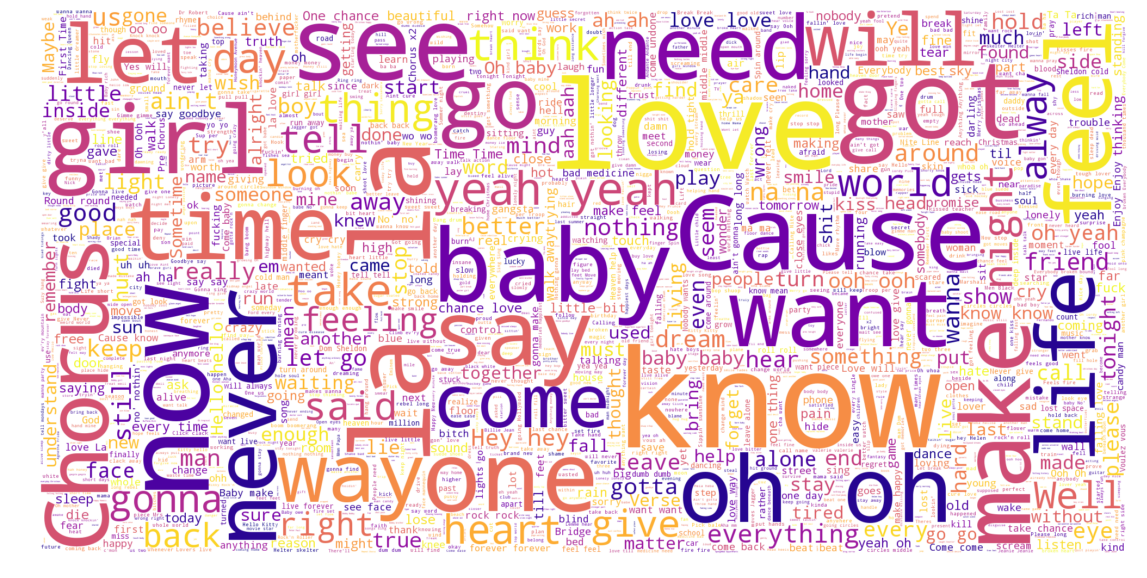

In [56]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
text = ""
for k,v in artist_list_dic.items():
    text += str(v["text"])

# ALL THE LYRICS IN THE $TEXT

# Generate a word cloud image
wc = WordCloud(width=2000,height=1000,max_words=2000,max_font_size=250,colormap="plasma",background_color="white")
wc.generate(text)

plt.figure(figsize=(20, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

## Plot 2: the most common used words in all artists
In this plot, which is similar to the plot 1, we can find some common words used among all artists.

### Data visualization 3
In this part, we will divide those lyrics into **2** parts by the gender of the artists. We want to see if artists in different gender will have different tendencies in lyric writing.
We use TF-IDF as the criterion. Generally, it means if a word is more important and more unique to its class, it would have a larger TF-IDF value.

Use sklearn to extract text features and calculate TF-IDF.

In [57]:
# Calculate the TF-IDF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
lyrics_all_df = data_parser.parse_csv_data('./data/lyrics.csv', 'ISO-8859-1')
mname = ["Bruno Mars", "The Beatles", "Maroon 5", "Backstreet Boys", "Bon Jovi", "Eminem", "Michael Jackson"]
#fname = ["Avril Lavigne", "Ariana Grande", "ABBA", "Britney Spears", "Adele", "Taylor Swift","Christina Aguilera"]
man_lyrics = ""
fem_lyrics = ""
for i in range(len(lyrics_all_df)):
    if mname.count(lyrics_all_df["artist"][i])>0 :
        man_lyrics = man_lyrics + " " + lyrics_all_df["text"][i]
    else:
        fem_lyrics = fem_lyrics + " " + lyrics_all_df["text"][i]
lyric_list = [man_lyrics, fem_lyrics]
count_vect = CountVectorizer(stop_words = 'english')
lyrics_counts = count_vect.fit_transform(lyric_list)
feat = count_vect.get_feature_names()
tf_transformer = TfidfTransformer().fit(lyrics_counts)
lyrics_tfidf = tf_transformer.transform(lyrics_counts)
tfidf = lyrics_tfidf.todense().tolist()

In [58]:
from bokeh.models import Rect
from bokeh.layouts import row
# Draw scatter graph
N = len(tfidf[0])
x = np.array(tfidf[0])
y = np.array(tfidf[1])
colors = ["#%02x%02x%02x" % (int(r), int(g), 100) for r, g in zip(300*x, 300*y)]

source0 = ColumnDataSource({'x': x, 'y': y, 'w': feat})
source1 = ColumnDataSource({'x': [], 'y': [], 'width': [], 'height': []})

jscode="""
    var data = source.data;
    var start = cb_obj.start;
    var end = cb_obj.end;
    data['%s'] = [start + (end - start) / 2];
    data['%s'] = [end - start];
    source.change.emit();
"""

# add hover tool
hover = HoverTool(tooltips=[('Word', '@w')])

p1 = figure(title='Pan and Zoom Here', x_range=(0, 0.32), y_range=(0, 0.32), x_axis_label="Maleness", y_axis_label="Femaleness",
            tools=['box_zoom,wheel_zoom,pan,reset',hover], plot_width=400, plot_height=400)
p1.scatter(x="x", y="y", size=5, fill_color=colors, fill_alpha=0.6, line_color=None, source=source0)

p1.x_range.callback = CustomJS(
        args=dict(source=source1), code=jscode % ('x', 'width'))
p1.y_range.callback = CustomJS(
        args=dict(source=source1), code=jscode % ('y', 'height'))

# add zoom range
p2 = figure(title='See Zoom Window Here', x_range=(0, 0.35), y_range=(0, 0.35), x_axis_label="Maleness", y_axis_label="Femaleness",
            tools='', plot_width=400, plot_height=400)
p2.scatter(x, y, fill_color=colors, fill_alpha=0.6, line_color=None)
rect = Rect(x='x', y='y', width='width', height='height', fill_alpha=0.1,
            line_color='black', fill_color='black')
p2.add_glyph(source1, rect)

layout = row(p1, p2)
show(layout)

/Users/zhiliyang/anaconda/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)


## Plot 3: the most common used words in all artists
As we can see from the plots above, male artists tend to use some words like **girl**, **aah**, **sxxt** in their songs; female artists tend to use **kitty**, **na**, **ah**, **sweet** in the songs.

### Cluster Visualization
Then we want to cluster those songs based on their lyrics' TF-IDF. Calculate every word's TF-IDF for each song, and use KMeans clustering, Spectral clustering, Agglomerative clustering algorithms for clustering.

At first, grab data we need and use sklearn again, but in different way.

In [59]:
artist_label = lyrics_all_df["artist"].tolist()
song_label = lyrics_all_df["song"].tolist()
song_lyric = lyrics_all_df["text"].tolist()

count_vect2 = CountVectorizer(stop_words = 'english')
song_lyric_counts = count_vect2.fit_transform(song_lyric)
feat2 = count_vect2.get_feature_names()
tf_transformer2 = TfidfTransformer().fit(lyrics_counts)
song_lyric_tfidf = tf_transformer2.transform(song_lyric_counts)
#print song_lyric_tfidf.shape

Then use KMeans clustering, Spectral clustering, Agglomerative clustering respectively and get the clustering results.

In [60]:
num_clusters = 5
from sklearn.cluster import KMeans
km = KMeans(n_clusters = num_clusters)
km.fit(song_lyric_tfidf)
#print len(km.labels_)
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters = num_clusters)
sc.fit(song_lyric_tfidf)
#print len(sc.labels_)
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters = num_clusters)
ac.fit(song_lyric_tfidf.toarray())

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=5,
            pooling_func=<function mean at 0x111581b70>)

Prepare data for the CustomJS interactive callback model.

In [61]:
labels = [km.labels_.tolist(), sc.labels_.tolist(), ac.labels_.tolist()]
info = [artist_label, song_label]
tfidf_dense = song_lyric_tfidf.todense().tolist()

top_words = []
cluster_pos = []

for cluster_labels in labels:
    # calculate the average tf-idf
    word_val = []
    for i in range(5):
        word_val.append([0 for i in range(len(feat2))])
    for i in range(len(cluster_labels)):
        for j in range(len(feat2)):
            word_val[cluster_labels[i]][j] += tfidf_dense[i][j]

    # Pick 5 most important words in each cluster
    max_num = 5
    word_idx = []
    word_labels = []
    for i in range(num_clusters):
        word_idx.append([])
    for i in range(num_clusters):
        arr = list(word_val[i])
        for j in range(max_num):
            idx = arr.index(max(arr))
            word_idx[i].append(idx)
            arr[idx] = 0
    for i in range(num_clusters):
        s = ''
        for j in word_idx[i]:
            s += feat[j]
            s += ' / '
        word_labels.append(s)
    
    top_words.append(word_labels)

    from sklearn.metrics.pairwise import cosine_similarity
    dist = 1 - cosine_similarity(song_lyric_tfidf)
    
    from sklearn.manifold import MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    pos = mds.fit_transform(dist)
    xs, ys = pos[:, 0], pos[:, 1]
    #print len(ys)
    
    pos = []
    for i in range(num_clusters):
        pos.append([])
    for i in range(num_clusters):
        pos[i].append([float("nan") for j in range(len(cluster_labels))])
        pos[i].append([float("nan") for j in range(len(cluster_labels))])
    for i in range(len(cluster_labels)):
        L = cluster_labels[i]
        pos[L][0][i] = xs[i]
        pos[L][1][i] = ys[i]
    
    cluster_pos.append(pos)

Draw those clusters. Use hover and select widget to get a better view and comparison.

In [62]:
from bokeh.layouts import widgetbox
x_attr = ["x0","x1","x2","x3","x4"]
y_attr = ["y0","y1","y2","y3","y4"]
data_cluster = {}
for i in range(num_clusters):
    data_cluster[x_attr[i]] = cluster_pos[0][i][0]
    data_cluster[y_attr[i]] = cluster_pos[0][i][1]

data_cluster["artist"] = artist_label
data_cluster["song"] = song_label
#print(song_label)
#print(len(top_words))
cache = [cluster_pos, top_words]
for i in range(len(labels[0])-2):
    cache.append([]) 
data_cluster["cache"] = cache

source = ColumnDataSource(data=data_cluster)

# add hover tool
hover2 = HoverTool(tooltips=[('Artist', '@artist'),("Song","@song")])

plot2 = figure(plot_width=900, plot_height=600, tools = [hover2])
plot2.background_fill_color = "lightgrey"
plot2.background_fill_alpha = 0.2

plot2.circle('x0' ,'y0' ,source=source, size=8, color="blue", alpha=0.5)
plot2.circle('x1' ,'y1' ,source=source, size=8, color="red", alpha=0.5)
plot2.circle('x2' ,'y2' ,source=source, size=8, color="green", alpha=0.5)
plot2.circle('x3' ,'y3' ,source=source, size=8, color="yellow", alpha=0.5)
plot2.circle('x4' ,'y4' ,source=source, size=8, color="purple", alpha=0.5)

callback = CustomJS(args=dict(source=source), code="""
    var data = source.data;
    var name = cb_obj.value;
    switch(name){
    case "KMeans":
        for (i = 0; i < data["x0"].length; i++) {
            data["x0"][i] = data["cache"][0][0][0][0][i]
            data["y0"][i] = data["cache"][0][0][0][1][i]
            data["x1"][i] = data["cache"][0][0][1][0][i]
            data["y1"][i] = data["cache"][0][0][1][1][i]
            data["x2"][i] = data["cache"][0][0][2][0][i]
            data["y2"][i] = data["cache"][0][0][2][1][i]
            data["x3"][i] = data["cache"][0][0][3][0][i]
            data["y3"][i] = data["cache"][0][0][3][1][i]
            data["x4"][i] = data["cache"][0][0][4][0][i]
            data["y4"][i] = data["cache"][0][0][4][1][i]
        }break;
    case "Spectral":
        for (i = 0; i < data["x0"].length; i++) {
            data["x0"][i] = data["cache"][0][1][0][0][i]
            data["y0"][i] = data["cache"][0][1][0][1][i]
            data["x1"][i] = data["cache"][0][1][1][0][i]
            data["y1"][i] = data["cache"][0][1][1][1][i]
            data["x2"][i] = data["cache"][0][1][2][0][i]
            data["y2"][i] = data["cache"][0][1][2][1][i]
            data["x3"][i] = data["cache"][0][1][3][0][i]
            data["y3"][i] = data["cache"][0][1][3][1][i]
            data["x4"][i] = data["cache"][0][1][4][0][i]
            data["y4"][i] = data["cache"][0][1][4][1][i]
        }break;
    case "Agglomerative":
        for (i = 0; i < data["x0"].length; i++) {
            data["x0"][i] = data["cache"][0][2][0][0][i]
            data["y0"][i] = data["cache"][0][2][0][1][i]
            data["x1"][i] = data["cache"][0][2][1][0][i]
            data["y1"][i] = data["cache"][0][2][1][1][i]
            data["x2"][i] = data["cache"][0][2][2][0][i]
            data["y2"][i] = data["cache"][0][2][2][1][i]
            data["x3"][i] = data["cache"][0][2][3][0][i]
            data["y3"][i] = data["cache"][0][2][3][1][i]
            data["x4"][i] = data["cache"][0][2][4][0][i]
            data["y4"][i] = data["cache"][0][2][4][1][i]
        }break;
    }
    source.change.emit();
""")

cluster_select = Select(title="Select Cluster Algorithm:", value="KMeans", options=["KMeans","Spectral","Agglomerative"])
cluster_select.js_on_change('value', callback)

show(column(plot2,widgetbox(cluster_select)))